## Description

In this notebook we are show information regarding the nanomet dataset and create a model that predicts the reflectivity value of a determined nanostructured surface. 

Specifically, we train Neural networks with the Keras library

### 1) Import libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import random

import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from sklearn import metrics
from sklearn.model_selection import KFold


# define a quick function for mean relative absolute error
def mean_relative_absolute_error(y_true, y_pred):
    x=sum(np.abs((y_true - y_pred)) / y_true ) /len(y_true)
    return x

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold

from tensorflow import keras
from tensorflow.keras.layers import *


from tensorflow.keras.models import Sequential


import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
#import tensorflow as tf

#import autokeras as ak

In [4]:
from sklearn.preprocessing import MinMaxScaler

### 2) Data exploration and analysis

In [69]:
#read the data with pandas and convert to a dataframe
df2 = pd.read_csv("data/grating_nanomet_v1.txt", sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])

In [70]:
#Add index simulation based on unique input values
df_col = df2.groupby(['h','top','base']).size().reset_index().rename(columns={0:'count'})
df3 = df2.reset_index().rename(columns = {'index': 'Simulation index'}, inplace = False)

i=1
for index, row in df_col.iterrows():
    df3.loc[(df3['h'] == row['h']) & (df3['top'] == row['top']) & (df3['base'] == row['base']),'Simulation index'] = i
    i+=1

In [161]:
df3.value_counts()

Simulation index  h    top  base   wavelength  Reflectance
1                 80   10   10.0   400.000000  0.044171       1
67                160  40   52.5   612.121212  0.020993       1
                                   590.909091  0.019761       1
                                   593.939394  0.020019       1
                                   596.969697  0.020229       1
                                                             ..
34                120  20   57.5   500.000000  0.017134       1
                                   503.030303  0.016927       1
                                   506.060606  0.016725       1
                                   509.090909  0.016535       1
100               200  50   100.0  700.000000  0.012974       1
Length: 10000, dtype: int64

In [162]:
df3.describe()

,Simulation index,h,top,base,wavelength,Reflectance
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.500000,140.000000,30.000000,55.000000,550.000000,0.025581
std,28.867513,44.723596,14.142843,22.639595,87.477314,0.011547
min,1.000000,80.000000,10.000000,10.000000,400.000000,0.000936
25%,25.750000,110.000000,20.000000,40.000000,475.000000,0.017444
50%,50.500000,140.000000,30.000000,55.000000,550.000000,0.025111
75%,75.250000,170.000000,40.000000,70.000000,625.000000,0.032912
max,100.000000,200.000000,50.000000,100.000000,700.000000,0.055296


In [9]:
len(df3['base'].unique())

25

In [10]:
df3[3900:4000]

,Simulation index,h,top,base,wavelength,Reflectance
3900,40,120,30,80.0,400.000000,0.013633
3901,40,120,30,80.0,403.030303,0.015904
3902,40,120,30,80.0,406.060606,0.016310
3903,40,120,30,80.0,409.090909,0.016411
3904,40,120,30,80.0,412.121212,0.016381
...,...,...,...,...,...,...
3995,40,120,30,80.0,687.878788,0.013889
3996,40,120,30,80.0,690.909091,0.014151
3997,40,120,30,80.0,693.939394,0.014414
3998,40,120,30,80.0,696.969697,0.014680


Text(0.5, 0, 'Wavelength (nm)')

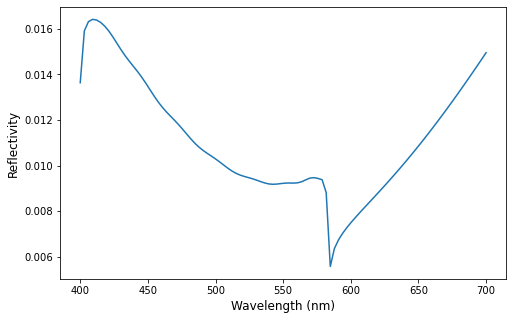

In [11]:
a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax,data=df3[3900:4000], x="wavelength", y='Reflectance')
plt.ylabel('Reflectivity',fontsize=12)
plt.xlabel('Wavelength (nm)',fontsize=12)

##### Ploting some of the spectrums

Text(0.5, 0, 'Wavelength (nm)')

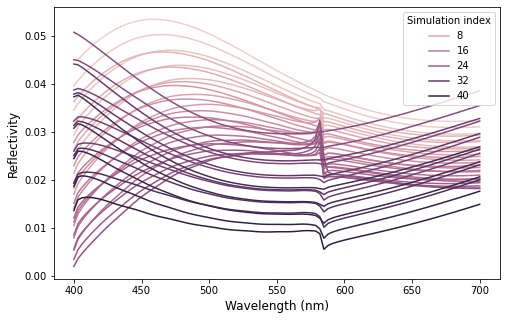

In [12]:
a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax,data=df3[1:4000], x="wavelength", y='Reflectance',hue = "Simulation index")
plt.ylabel('Reflectivity',fontsize=12)
plt.xlabel('Wavelength (nm)',fontsize=12)

Text(0.5, 0, 'Wavelength (nm)')

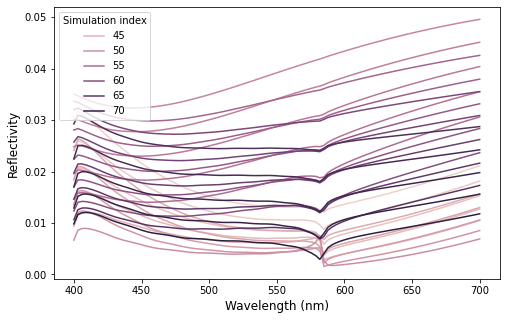

In [13]:
a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax,data=df3[4000:7000], x="wavelength", y='Reflectance',hue = "Simulation index")
plt.ylabel('Reflectivity',fontsize=12)
plt.xlabel('Wavelength (nm)',fontsize=12)

Text(0.5, 0, 'Wavelength (nm)')

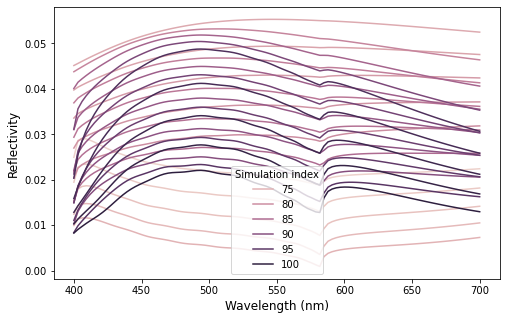

In [14]:
a4_dims = (8, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(ax=ax,data=df3[7000:10000], x="wavelength", y='Reflectance',hue = "Simulation index")
plt.ylabel('Reflectivity',fontsize=12)
plt.xlabel('Wavelength (nm)',fontsize=12)

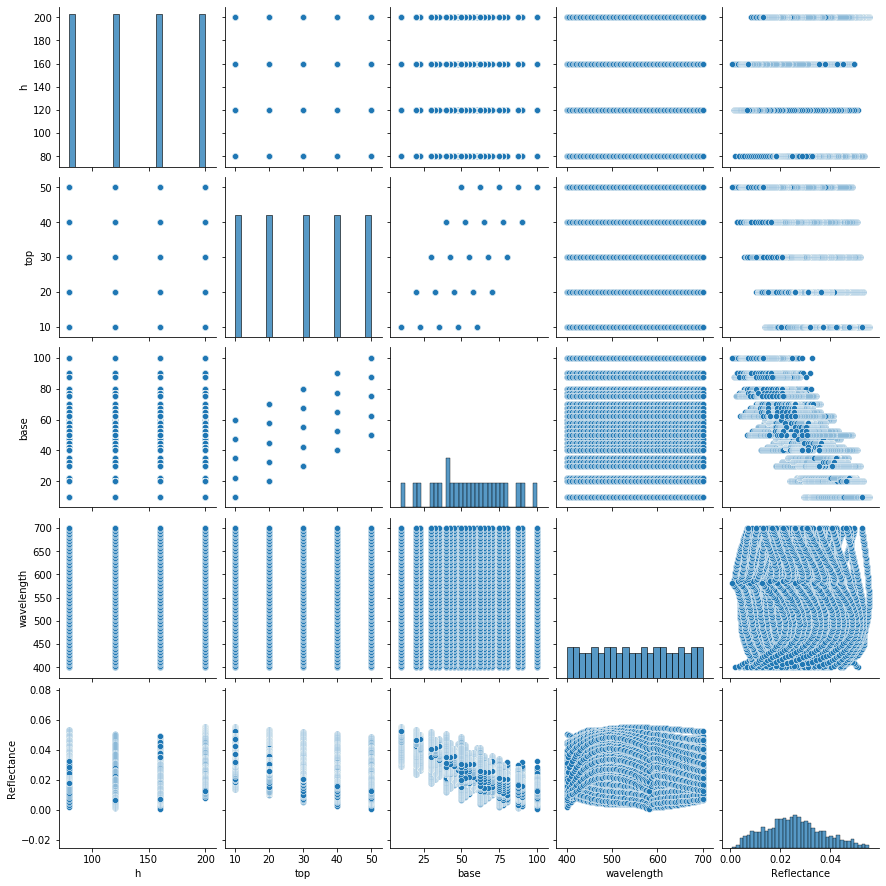

In [12]:
sns.pairplot(df3[['h','top','base','wavelength','Reflectance']])

### 3) Feature Engineering

In the following cells, we will engineer the variables of our Dataset so that we tackle:


* Put the variables in a similar scale


Small note that for the Random forest model this is not required

### 3) Feature Selection

Due to the low number of features, we are not going to add more.

However, if we see that our models are not perfoming well we can combine some features to help the trainning! (Source: https://pubmed.ncbi.nlm.nih.gov/31684518/)

### 5) Model Training

In [7]:
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [8]:
#getting our features
features = df3.drop(['Simulation index', 'Reflectance'],axis= 1).columns.tolist()

#### 5.1) Neural Networks

In [9]:
scaler_1 = MinMaxScaler()

df3[['h','top','base','wavelength']] = scaler_1.fit_transform(df3[['h','top','base','wavelength']])

In [10]:
df4 = df3[(df3['Simulation index'] != 13) & (df3['Simulation index'] != 14) & (df3['Simulation index'] != 15) & (df3['Simulation index'] != 70) & (df3['Simulation index'] != 71)]

In [11]:
df5 = df3[(df3['Simulation index'] == 13) | (df3['Simulation index'] == 14) | (df3['Simulation index'] == 15) | (df3['Simulation index'] == 70) | (df3['Simulation index'] == 71)]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df4.drop(['Simulation index', 'Reflectance'], axis=1), # predictive variables
    df4['Reflectance'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((7600, 4), (1900, 4))

In [13]:
len(X_train)

7600

In [13]:
# get the model
def get_model(n_inputs, n_outputs):
    
	net1Model=keras.models.Sequential()
	net1Model.add(Dense(n_inputs,input_shape=(4,)))
	#net1Model.add(Activation('relu'))
	net1Model.add(Dense(240))
	net1Model.add(Activation('relu'))
	#net1Model.add(Dropout(0.5))
	net1Model.add(Dense(30))
	net1Model.add(Activation('relu'))
	#net1Model.add(Dropout(0.4))
#	net1Model.add(Dense(400))
#	net1Model.add(Dropout(0.6))
#	net1Model.add(Dense(400))
	#net1Model.add(Dropout(0.2))
	net1Model.add(Dense(1024))
    #net1Model.add(GaussianNoise(1.0))
	net1Model.add(Dense(n_outputs))
	net1Model.compile(optimizer='Adam',loss='mse')
    #net1Model.fit(X1, y1,epochs=1000,verbose=0)
	#model.compile(loss='mae', optimizer='adam')
    
	return net1Model


Here we train the model and show the error of the actual test values compared to the predicted ones from the random heldout test dataset

If you want to see the training progress put verbose = 1

60/60 [==============================] - 0s 856us/step - loss: 1.2333e-07


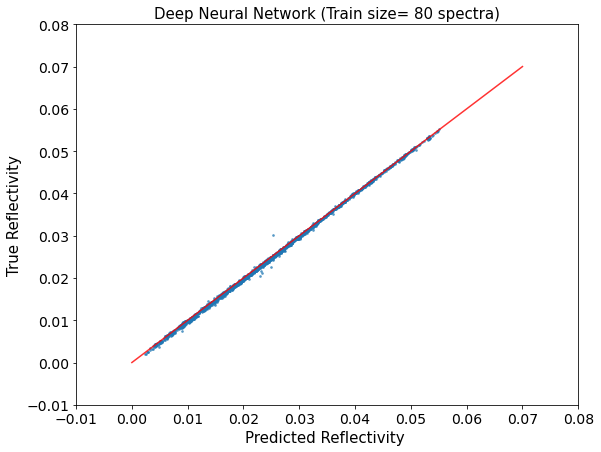

In [14]:
n_inputs, n_outputs = X_train.shape[1],1
model_forward = get_model(n_inputs, n_outputs)

# fit model
model_forward.fit(X_train, y_train, verbose=0, epochs=2000)

# evaluate model on test set
#mae = model.evaluate(X_train, y_train, verbose=0)
mae = model_forward.evaluate(X_test, y_test, verbose=1)    
pred= model_forward.predict(X_test)

plt.figure(figsize=(9,7))
plt.scatter(pred,y_test,alpha=0.6,s=3)
plt.plot([0, 0.07],[0, 0.07],'r',alpha=0.8)
plt.ylabel('True Reflectivity',fontsize=15)
plt.xlabel('Predicted Reflectivity ',fontsize=15)
plt.title('Deep Neural Network (Train size= 80 spectra)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.01, 0.08])
plt.ylim([-0.01,  0.08])
plt.show()


#### Test the data on heldout and train spectra

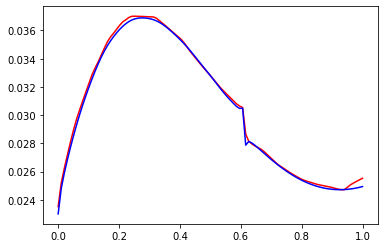

In [16]:

df_helout = df3[df3['Simulation index'] == 12]
pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

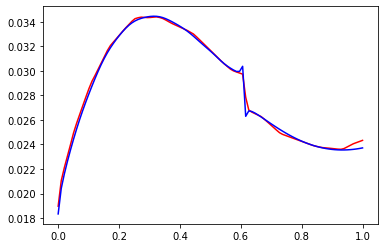

In [17]:

df_helout = df3[df3['Simulation index'] == 13]
pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

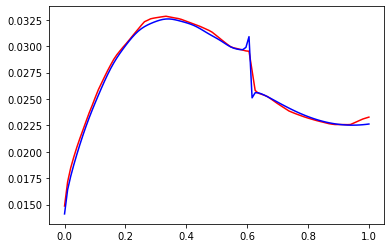

In [18]:

df_helout = df3[df3['Simulation index'] == 14]
pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

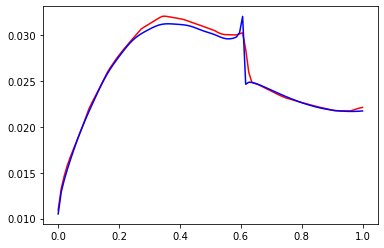

In [19]:
df_helout = df3[df3['Simulation index'] == 15]

pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately

plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 

plt.show()



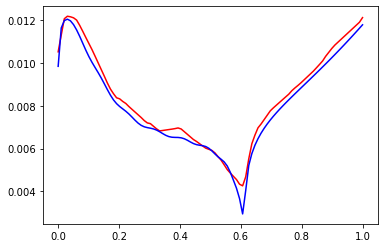

In [20]:

df_helout = df3[df3['Simulation index'] == 70]
pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()


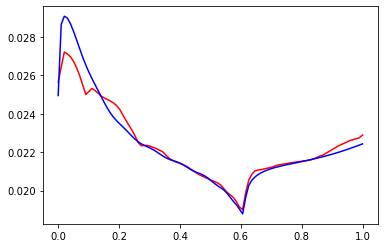

In [21]:

df_helout = df3[df3['Simulation index'] == 71]
pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()


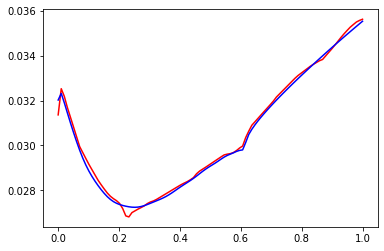

In [22]:

df_helout = df3[df3['Simulation index'] == 61]
pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

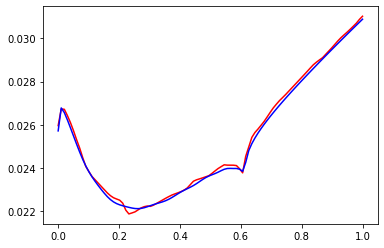

In [23]:

df_helout = df3[df3['Simulation index'] == 62]
pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

In [248]:
#What is the time for running modeling?

#### Check for overfiting 

In [22]:
#Checking overfit for different epochs of training 
mean_mae_list_train_set = []
mean_mae_list_test_set = []
mean_mae_list_val_set = []

std_mae_list_train_set = []
std_mae_list_test_set = []
std_mae_list_val_set = []

for epochs_num in range(100,2100,100):
    mae_list_train_set = []
    mae_list_test_set = []
    mae_list_val_set = []
    
    for i in range(1,5,1):
        n_inputs, n_outputs = X_train.shape[1],1
        model_forward = get_model(n_inputs, n_outputs)
        print(epochs_num)
        # fit model
        model_forward.fit(X_train, y_train, verbose=0, epochs = epochs_num)

        # evaluate model on test set
        mae_list_train_set.append( model_forward.evaluate(X_train, y_train, verbose=0))
        mae_list_test_set.append( model_forward.evaluate(X_test, y_test, verbose=0) )
        #pred_2 = model.predict(df5[['h','top',	'base',	'wavelength']],df5['Reflectance'])
        mae_list_val_set.append(model_forward.evaluate(df5[['h','top',	'base',	'wavelength']], df5['Reflectance'], verbose=0))
    
    mean_mae_list_train_set.append( np.mean(mae_list_train_set))
    mean_mae_list_test_set.append( np.mean(mae_list_test_set))
    mean_mae_list_val_set.append( np.mean(mae_list_val_set))
    std_mae_list_train_set.append( np.std(mae_list_train_set))
    std_mae_list_test_set.append( np.std(mae_list_test_set))
    std_mae_list_val_set.append( np.std(mae_list_val_set))
    
#pred= model.predict(X_test,y_test)


100
100
100
100
200
200
200
200
300
300
300
300
400
400
400
400
500
500
500
500
600
600
600
600
700
700
700
700
800
800
800
800
900
900
900
900
1000
1000
1000
1000
1100
1100
1100
1100
1200
1200
1200
1200
1300
1300
1300
1300
1400
1400
1400
1400
1500
1500
1500
1500
1600
1600
1600
1600
1700
1700
1700
1700
1800


KeyboardInterrupt: 

In [ ]:

from pylab import figure, show, legend, ylabel
import matplotlib.ticker as ticker
# create the general figure
fig1 = figure(figsize=(9,8))
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
#line1 = ax1.errorbar(df_for1 ['Train_size'],df_for1 ['mean_Final_RMSE'], yerr=df_for1 ['std_final_rmse'],ecolor='black',fmt='--o',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='green')
#ax1.legend(['mean_RMSE_percentage'],loc=2)
#line1 = ax1.errorbar(df_for1 ['Train_size'],df_for1 ['training_rmse'], yerr=df_for1 ['std_final_rmse'],ecolor='black',fmt='--o',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='black')
x_space = np.linspace(100, 2100, num=20)

line1 = ax1.errorbar(x_space,mean_mae_list_train_set, yerr=std_mae_list_train_set,ecolor='black',fmt='--^',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='green')
ax1.legend(['train_set_mae'],loc=2)

line2 = ax1.errorbar(x_space,mean_mae_list_test_set, yerr=std_mae_list_test_set,ecolor='black',fmt='-*',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='blue')
ax1.legend(['test_set_mae'],loc=2)

line2 = ax1.errorbar(x_space,mean_mae_list_val_set, yerr=std_mae_list_val_set,ecolor='black',fmt='--*',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='red')
ax1.legend(['heldout_set_mae'],loc=2)

#plt.legend(('mae_list_train', 'mae_list_test', 'mae_list_val'),
          # loc='upper center', shadow=True)
ylabel('Mean absolut error (mae)',fontsize=15)
plt.xlabel('Num of epochs (arb. units)',fontsize=15)
# now, the second axes that shares the x-axis with the ax1
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
#line2 = ax2.errorbar(df_new5 ['Train_size'],df_new5 ['mean_relative_absolute_error'], yerr=df_new5 ['std_mean_relative_absolute_error'],ecolor='black',fmt='xr-',capthick=2)
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.legend(["mean_rel_absolute_error"],loc=1)
#ylabel('mean_rel_absolute_error')
plt.title('Deep Neural Networks with 80% train set',fontsize=15)
plt.xticks(rotation = 45)

tick_spacing =500
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(direction='out', length=7, width=2,
                grid_alpha=0.5,labelsize=12)

#legend = ax1.legend(loc='down center', shadow=True, fontsize='x-large')

#ax1.set_yscale("log", nonposy='clip')
plt.grid(True)

show()

In [ ]:
#Overfit check with number of data for training

In [ ]:
#Checking overfit for different epochs of training 
mean_mae_list_train_set = []
mean_mae_list_test_set = []
mean_mae_list_val_set = []

std_mae_list_train_set = []
std_mae_list_test_set = []
std_mae_list_val_set = []

n_epochs = 2000

for test_size_value in [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]:
    mae_list_train_set = []
    mae_list_test_set = []
    mae_list_val_set = []
    
    X_train, X_test, y_train, y_test = train_test_split(
    df4.drop(['Simulation index', 'Reflectance'], axis=1), # predictive variables
    df4['Reflectance'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
        )
    print(test_size_value)
    for i in range(1,5,1):
        n_inputs, n_outputs = X_train.shape[1],1
        model_forward = get_model(n_inputs, n_outputs)
        #print(epochs_num)
        # fit model
        model_forward.fit(X_train, y_train, verbose=0, epochs = epochs_num)

        # evaluate model on test set
        mae_list_train_set.append( model_forward.evaluate(X_train, y_train, verbose=0))
        mae_list_test_set.append( model_forward.evaluate(X_test, y_test, verbose=0) )
        #pred_2 = model.predict(df5[['h','top',	'base',	'wavelength']],df5['Reflectance'])
        mae_list_val_set.append(model_forward.evaluate(df5[['h','top',	'base',	'wavelength']], df5['Reflectance'], verbose=0))
        del model_forward
        
    mean_mae_list_train_set.append( np.mean(mae_list_train_set))
    mean_mae_list_test_set.append( np.mean(mae_list_test_set))
    mean_mae_list_val_set.append( np.mean(mae_list_val_set))
    std_mae_list_train_set.append( np.std(mae_list_train_set))
    std_mae_list_test_set.append( np.std(mae_list_test_set))
    std_mae_list_val_set.append( np.std(mae_list_val_set))
    
#pred= model.predict(X_test,y_test)

In [ ]:
from pylab import figure, show, legend, ylabel
import matplotlib.ticker as ticker
# create the general figure
fig1 = figure(figsize=(9,8))
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
x_space = [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]


line1 = ax1.errorbar(x_space,mean_mae_list_train_set, yerr=std_mae_list_train_set,ecolor='black',fmt='--^',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='green')
ax1.legend(['train_set_mae'],loc=2)

line2 = ax1.errorbar(x_space,mean_mae_list_test_set, yerr=std_mae_list_test_set,ecolor='black',fmt='-*',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='blue')
ax1.legend(['test_set_mae'],loc=2)

line2 = ax1.errorbar(x_space,mean_mae_list_val_set, yerr=std_mae_list_val_set,ecolor='black',fmt='--*',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='red')
ax1.legend(['heldout_set_mae'],loc=2)


ylabel('Mean absolut error (mae)',fontsize=15)
plt.xlabel('Test size ',fontsize=15)
# now, the second axes that shares the x-axis with the ax1
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
#line2 = ax2.errorbar(df_new5 ['Train_size'],df_new5 ['mean_relative_absolute_error'], yerr=df_new5 ['std_mean_relative_absolute_error'],ecolor='black',fmt='xr-',capthick=2)
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.legend(["mean_rel_absolute_error"],loc=1)
#ylabel('mean_rel_absolute_error')
plt.title('Deep Neural Networks with 2000 epochs',fontsize=15)
plt.xticks(rotation = 45)

tick_spacing =0.05
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(direction='out', length=7, width=2,
                grid_alpha=0.5,labelsize=12)

#legend = ax1.legend(loc='down center', shadow=True, fontsize='x-large')

#ax1.set_yscale("log", nonposy='clip')
plt.grid(True)

show()

### Inverse problem

In [16]:
#Importing again the dataset 

#Add index simulation based on unique input values
df_col = df2.groupby(['h','top','base']).size().reset_index().rename(columns={0:'count'})
df3 = df2.reset_index().rename(columns = {'index': 'Simulation index'}, inplace = False)

i=1
for index, row in df_col.iterrows():
    df3.loc[(df3['h'] == row['h']) & (df3['top'] == row['top']) & (df3['base'] == row['base']),'Simulation index'] = i
    i+=1

In [17]:
#we need to reshape our data

In [18]:
scaler = MinMaxScaler()

df3[['h','top','base']] = scaler.fit_transform(df3[['h','top',	'base']])

In [19]:
df3

,Simulation index,h,top,base,wavelength,Reflectance
0,1,0.0,0.0,0.0,400.000000,0.044171
1,1,0.0,0.0,0.0,403.030303,0.045151
2,1,0.0,0.0,0.0,406.060606,0.046044
3,1,0.0,0.0,0.0,409.090909,0.046886
4,1,0.0,0.0,0.0,412.121212,0.047678
...,...,...,...,...,...,...
9995,100,1.0,1.0,1.0,687.878788,0.013585
9996,100,1.0,1.0,1.0,690.909091,0.013426
9997,100,1.0,1.0,1.0,693.939394,0.013271
9998,100,1.0,1.0,1.0,696.969697,0.013120


In [20]:
grouped_df = df3.groupby(['Simulation index','h','top','base'])

In [21]:
grouped_df = grouped_df.apply(lambda x: x['Reflectance'].unique())

In [22]:
grouped_df = grouped_df.to_frame().reset_index()
grouped_df = grouped_df.rename(columns= {0: 'Reflectance'})

In [23]:
grouped_df

,Simulation index,h,top,base,Reflectance
0,1,0.0,0.0,0.000000,"[0.0441705845518706, 0.0451512878134928, 0.046..."
1,2,0.0,0.0,0.138889,"[0.0396313691881517, 0.040764051987158, 0.0417..."
2,3,0.0,0.0,0.277778,"[0.0345976283250554, 0.035954689964802, 0.0369..."
3,4,0.0,0.0,0.416667,"[0.0294282118029957, 0.0310594583102924, 0.032..."
4,5,0.0,0.0,0.555556,"[0.0244563302543115, 0.0263763566979613, 0.027..."
...,...,...,...,...,...
95,96,1.0,1.0,0.444444,"[0.0203499709151945, 0.0255063036653046, 0.028..."
96,97,1.0,1.0,0.583333,"[0.0158880769961786, 0.0184102397047299, 0.020..."
97,98,1.0,1.0,0.722222,"[0.0128478412156016, 0.0142843907190416, 0.015..."
98,99,1.0,1.0,0.861111,"[0.0103134675732409, 0.0113613487127233, 0.012..."


In [24]:
#Now we just make our train test set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    grouped_df.drop(['Simulation index', 'h','top','base'], axis=1), # predictive variables
    grouped_df[['h','top','base']], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=1, # we are setting the seed here
)

X_train.shape, X_test.shape

((80, 1), (20, 1))

In [26]:
y_test

,h,top,base
80,1.000000,0.25,0.111111
84,1.000000,0.25,0.666667
33,0.333333,0.25,0.527778
81,1.000000,0.25,0.250000
93,1.000000,0.75,0.750000
17,0.000000,0.75,0.611111
36,0.333333,0.50,0.361111
82,1.000000,0.25,0.388889
69,0.666667,0.75,0.888889
65,0.666667,0.75,0.333333


In [27]:
# get the model
def get_model(n_inputs, n_outputs):
    
	net1Model=keras.models.Sequential()
	net1Model.add(Dense(n_inputs))
	#net1Model.add(Activation('relu'))
	net1Model.add(Dense(240))
	net1Model.add(Activation('relu'))
	#net1Model.add(Dropout(0.5))
	net1Model.add(Dense(30))
	net1Model.add(Activation('relu'))
	#net1Model.add(Dropout(0.4))
#	net1Model.add(Dense(400))
#	net1Model.add(Dropout(0.6))
#	net1Model.add(Dense(400))
	#net1Model.add(Dropout(0.2))
	net1Model.add(Dense(1024))
    #net1Model.add(GaussianNoise(1.0))
	net1Model.add(Dense(n_outputs))
	net1Model.compile(optimizer='Adam',loss='mse')
    #net1Model.fit(X1, y1,epochs=1000,verbose=0)
	#model.compile(loss='mae', optimizer='adam')
    
	return net1Model

In [28]:
X_train.head()

,Reflectance
2,"[0.0345976283250554, 0.035954689964802, 0.0369..."
73,"[0.0124214473106007, 0.0142867077334515, 0.014..."
97,"[0.0128478412156016, 0.0142843907190416, 0.015..."
62,"[0.019739546358155, 0.0214662995018069, 0.0214..."
19,"[0.0053916374164843, 0.007621227210415, 0.0089..."


In [29]:
#spitted column

X_train = pd.DataFrame(X_train["Reflectance"].to_list())
X_test = pd.DataFrame(X_test["Reflectance"].to_list())

In [37]:
n_inputs, n_outputs = X_train.shape[1],3
model = get_model(n_inputs, n_outputs)

# fit model
model.fit(X_train, y_train, verbose=0, epochs=600)

# evaluate model on test set
#mae = model.evaluate(X_train, y_train, verbose=0)
mae = model.evaluate(X_test, y_test, verbose=1)    


1/1 [==============================] - 0s 1ms/step - loss: 0.0010


In [38]:
pred= model.predict(X_test)
df_pred = pd.DataFrame(data=pred, columns=['h','top','base'])

In [39]:
df_pred

,h,top,base
0,0.994782,0.230854,0.074101
1,0.989238,0.323766,0.647356
2,0.319893,0.247610,0.532438
3,1.000900,0.244776,0.242778
4,0.994222,0.750457,0.752834
5,-0.008331,0.728122,0.608965
6,0.328798,0.485509,0.370487
7,0.997241,0.226872,0.397256
8,0.707691,0.761316,0.937314
9,0.654652,0.682457,0.353740


In [40]:
df_pred_inverse = scaler.inverse_transform(df_pred)

In [41]:
df_pred_inverse

array([[199.37386 ,  19.234175,  16.669077],
       [198.70854 ,  22.950645,  68.262054],
       [118.387215,  19.904404,  57.91942 ],
       [200.10803 ,  19.79106 ,  31.850033],
       [199.3066  ,  40.018265,  77.75506 ],
       [ 79.000336,  39.12489 ,  64.80685 ],
       [119.45572 ,  29.420374,  43.343792],
       [199.66893 ,  19.074898,  45.75302 ],
       [164.92297 ,  40.452633,  94.35828 ],
       [158.55827 ,  37.29827 ,  41.836586],
       [201.44447 ,  41.361332,  64.37174 ],
       [116.62085 ,  33.320858,  76.33136 ],
       [159.35483 ,  19.689798,  30.520777],
       [158.94075 ,  11.859377,  33.8318  ],
       [158.2446  ,  11.015214,  21.12075 ],
       [119.72835 ,  19.420988,  45.77641 ],
       [119.65687 ,  19.327808,  32.557583],
       [116.00959 ,  45.60255 ,  84.27331 ],
       [199.07414 ,   9.935062,  47.351204],
       [ 78.65215 ,  28.161564,  31.249172]], dtype=float32)

In [42]:
df_pred_inverse = scaler.inverse_transform(df_pred)
df_test_inverse = scaler.inverse_transform(y_test)

In [43]:
df_pred_inverse = pd.DataFrame(data=df_pred_inverse, columns=['h','top','base'])
df_test_inverse = pd.DataFrame(data=df_test_inverse, columns=['h','top','base'])


In [44]:
df_test_inverse

,h,top,base
0,200.0,20.0,20.0
1,200.0,20.0,70.0
2,120.0,20.0,57.5
3,200.0,20.0,32.5
4,200.0,40.0,77.5
5,80.0,40.0,65.0
6,120.0,30.0,42.5
7,200.0,20.0,45.0
8,160.0,40.0,90.0
9,160.0,40.0,40.0


In [45]:
from sklearn.metrics import mean_absolute_error

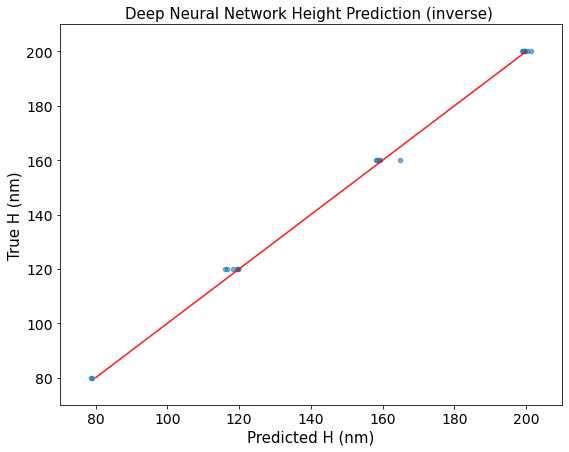

1.3866943359374957

In [46]:
plt.figure(figsize=(9,7))
plt.scatter(df_pred_inverse['h'],df_test_inverse['h'],alpha=0.6,s=20)
plt.plot([80, 200],[80, 200],'r',alpha=0.9)
plt.ylabel('True H (nm)',fontsize=15)
plt.xlabel('Predicted H (nm)',fontsize=15)
plt.title('Deep Neural Network Height Prediction (inverse) ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([70, 210])
plt.ylim([70, 210])

plt.show()

mean_absolute_error(df_pred_inverse['h'],df_test_inverse['h'])

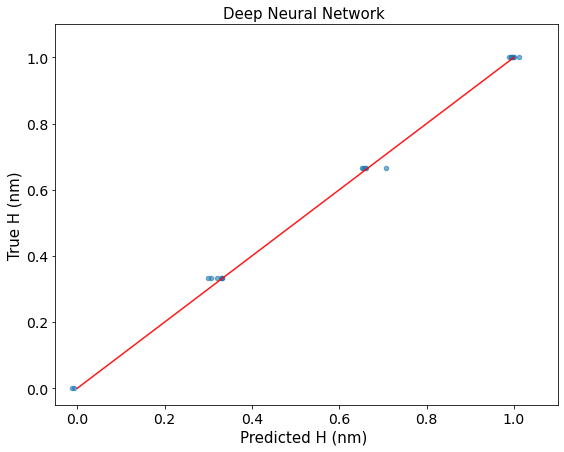

0.011555788014084106

In [47]:


plt.figure(figsize=(9,7))
plt.scatter(df_pred['h'],y_test['h'],alpha=0.6,s=20)
plt.plot([0, 1],[0, 1],'r',alpha=0.9)
plt.ylabel('True H (nm)',fontsize=15)
plt.xlabel('Predicted H (nm) ',fontsize=15)
plt.title('Deep Neural Network ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.05, 1.1])
plt.ylim([-0.05, 1.1])

plt.show()
mean_absolute_error(df_pred['h'],y_test['h'])

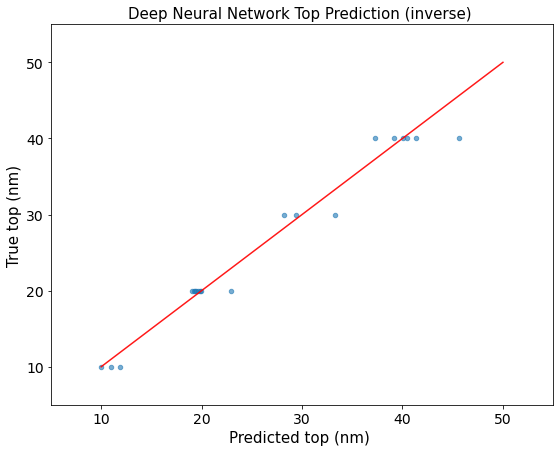

1.3098791599273683

In [48]:
plt.figure(figsize=(9,7))
plt.scatter(df_pred_inverse['top'],df_test_inverse['top'],alpha=0.6,s=20)
plt.plot([10, 50],[10, 50],'r',alpha=0.9)
plt.ylabel('True top (nm)',fontsize=15)
plt.xlabel('Predicted top (nm) ',fontsize=15)
plt.title('Deep Neural Network Top Prediction (inverse) ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([5, 55])
plt.ylim([5, 55])

plt.show()

mean_absolute_error(df_pred_inverse['top'],df_test_inverse['top'])

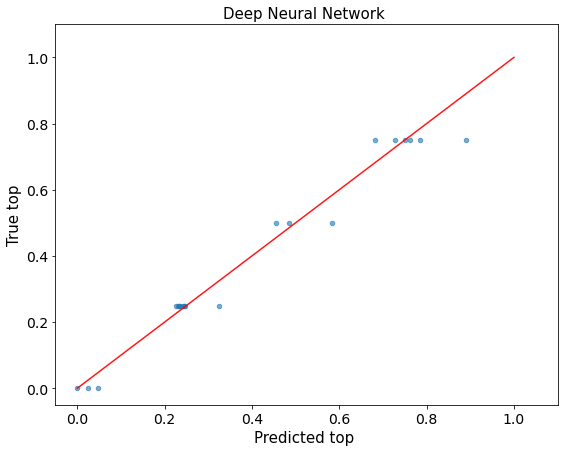

0.032746975356712935

In [49]:


plt.figure(figsize=(9,7))
plt.scatter(df_pred['top'],y_test['top'],alpha=0.6,s=20)
plt.plot([0, 1],[0, 1],'r',alpha=0.9)
plt.ylabel('True top',fontsize=15)
plt.xlabel('Predicted top ',fontsize=15)
plt.title('Deep Neural Network ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.05, 1.1])
plt.ylim([-0.05, 1.1])

plt.show()
mean_absolute_error(df_pred['top'],y_test['top'])

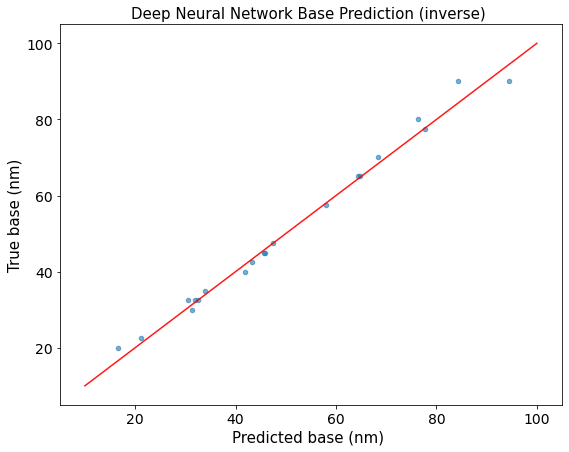

1.5580183029174803

In [50]:
plt.figure(figsize=(9,7))
plt.scatter(df_pred_inverse['base'],df_test_inverse['base'],alpha=0.6,s=20)
plt.plot([10, 100],[10, 100],'r',alpha=0.9)
plt.ylabel('True base (nm)',fontsize=15)
plt.xlabel('Predicted base (nm) ',fontsize=15)
plt.title('Deep Neural Network Base Prediction (inverse) ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([5, 105])
plt.ylim([5, 105])

plt.show()
mean_absolute_error(df_pred_inverse['base'],df_test_inverse['base'])

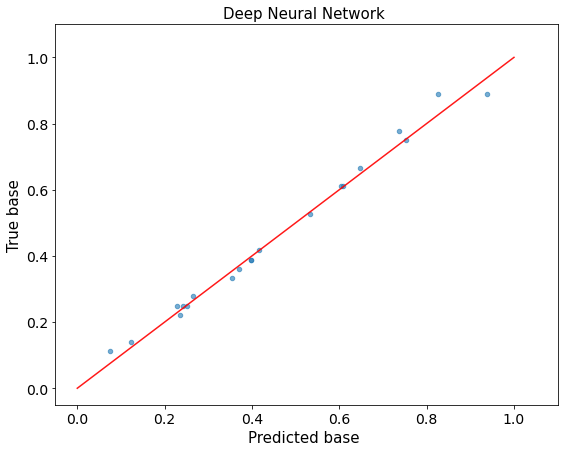

0.017311310436990513

In [51]:


plt.figure(figsize=(9,7))
plt.scatter(df_pred['base'],y_test['base'],alpha=0.6,s=20)
plt.plot([0, 1],[0, 1],'r',alpha=0.9)
plt.ylabel('True base',fontsize=15)
plt.xlabel('Predicted base ',fontsize=15)
plt.title('Deep Neural Network ',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.05, 1.1])
plt.ylim([-0.05, 1.1])

plt.show()
mean_absolute_error(df_pred['base'],y_test['base'])

In [52]:
pred= model.predict(X_train)
df_pred = pd.DataFrame(data=pred, columns=['h','top','base'])

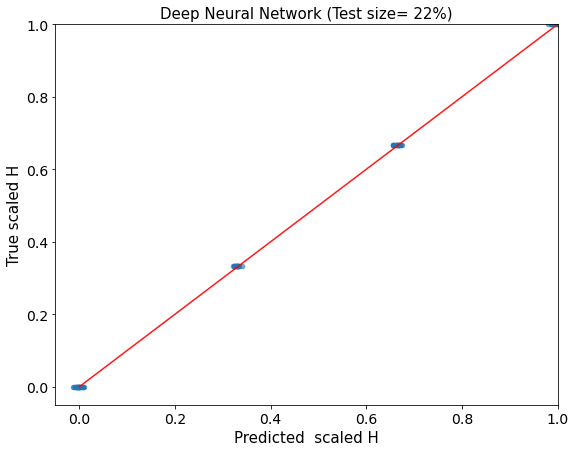

In [53]:

plt.figure(figsize=(9,7))
plt.scatter(df_pred['h'],y_train['h'],alpha=0.6,s=20)
plt.plot([0, 1],[0, 1],'r',alpha=0.9)
plt.ylabel('True scaled H',fontsize=15)
plt.xlabel('Predicted  scaled H',fontsize=15)
plt.title('Deep Neural Network (Test size= 22%)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.05, 1])
plt.ylim([-0.05, 1])

plt.show()

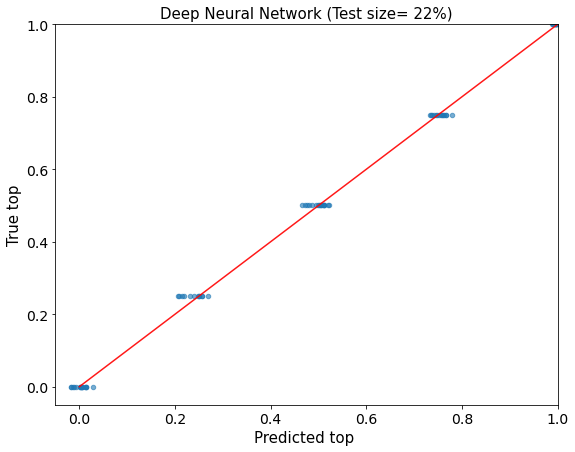

In [54]:

plt.figure(figsize=(9,7))
plt.scatter(df_pred['top'],y_train['top'],alpha=0.6,s=20)
plt.plot([0, 60],[0, 60],'r',alpha=0.9)
plt.ylabel('True top',fontsize=15)
plt.xlabel('Predicted top ',fontsize=15)
plt.title('Deep Neural Network (Test size= 22%)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.05, 1])
plt.ylim([-0.05, 1])

plt.show()


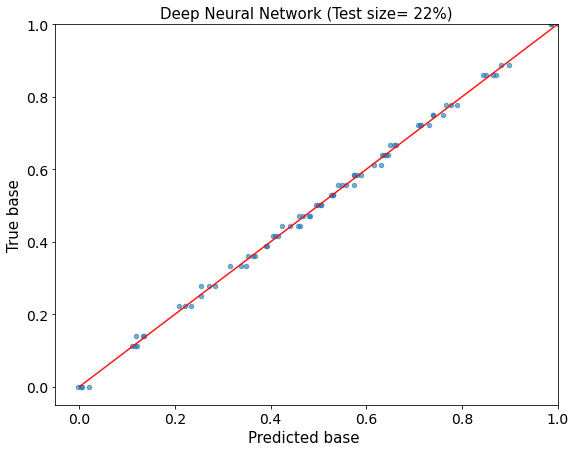

In [60]:
plt.figure(figsize=(9,7))
plt.scatter(df_pred['base'],y_train['base'],alpha=0.6,s=20)
plt.plot([0, 50],[0, 50],'r',alpha=0.9)
plt.ylabel('True base',fontsize=15)
plt.xlabel('Predicted base ',fontsize=15)
plt.title('Deep Neural Network (Test size= 22%)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.05, 1])
plt.ylim([-0.05, 1])
plt.show()

In [61]:
df_pred

,h,top,base
0,0.004424,0.022821,0.254295
1,0.662745,0.982163,0.864372
2,1.013058,0.981705,0.707407
3,0.668498,0.489520,0.504244
4,0.010791,0.746020,0.881950
...,...,...,...
75,1.016271,-0.011245,0.002592
76,0.004061,0.260922,0.658542
77,0.668619,0.977864,0.713535
78,-0.003360,0.493515,0.495248


In [62]:
#Inverse the transformation of the predicted features 

In [63]:
df_pred_inverse = scaler.inverse_transform(df_pred)

In [64]:
df_test_inverse = scaler.inverse_transform(y_test)

### Check for overfiting

#### For different epochs

In [36]:
#Checking overfit for different epochs of training 
mae_list_train_set = []
mae_list_test_set = []

for epochs_num in range(100,2100,100):
    n_inputs, n_outputs = X_train.shape[1],3
    model = get_model(n_inputs, n_outputs)
    print(epochs_num)
    # fit model
    model.fit(X_train, y_train, verbose=0, epochs = epochs_num)

    # evaluate model on test set
    mae_list_train_set.append( model.evaluate(X_train, y_train, verbose=0))
    mae_list_test_set.append( model.evaluate(X_test, y_test, verbose=0) )
    
    #for the subplot error
    
    df_pred = pd.DataFrame(data=pred, columns=['h','top','base'])
    
    
    del model
    #pred_2 = model.predict(df5[['h','top',	'base',	'wavelength']],df5['Reflectance'])
    #mae_list_val_set.append(model.evaluate(df5[['h','top',	'base',	'wavelength']], df5['Reflectance'], verbose=0))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [37]:
model.evaluate(X_train, y_train, verbose=0)


NameError: name 'model' is not defined

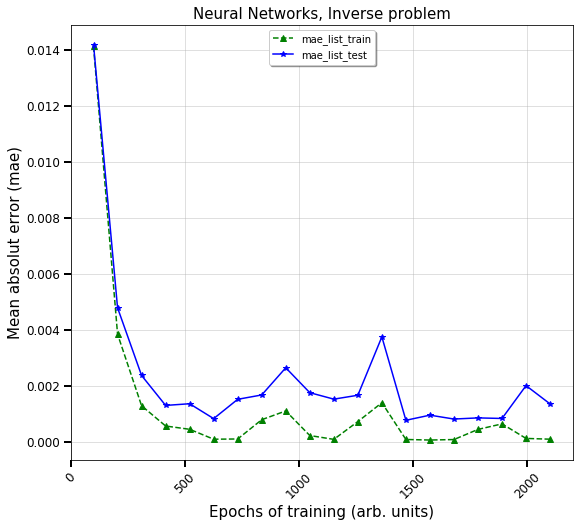

In [38]:

from pylab import figure, show, legend, ylabel
import matplotlib.ticker as ticker
# create the general figure
fig1 = figure(figsize=(9,8))
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
#line1 = ax1.errorbar(df_for1 ['Train_size'],df_for1 ['mean_Final_RMSE'], yerr=df_for1 ['std_final_rmse'],ecolor='black',fmt='--o',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='green')
#ax1.legend(['mean_RMSE_percentage'],loc=2)
#line1 = ax1.errorbar(df_for1 ['Train_size'],df_for1 ['training_rmse'], yerr=df_for1 ['std_final_rmse'],ecolor='black',fmt='--o',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='black')
plt.plot(np.linspace(100, 2100, num=20), mae_list_train_set, '--g^')
plt.plot(np.linspace(100, 2100, num=20), mae_list_test_set, '-b*')
#plt.plot(np.linspace(100, 2100, num=20), mae_list_val_set, '--r*')
plt.legend(('mae_list_train', 'mae_list_test', 'mae_list_val'),
           loc='upper center', shadow=True)
ylabel('Mean absolut error (mae)',fontsize=15)
plt.xlabel('Epochs of training (arb. units)',fontsize=15)
# now, the second axes that shares the x-axis with the ax1
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
#line2 = ax2.errorbar(df_new5 ['Train_size'],df_new5 ['mean_relative_absolute_error'], yerr=df_new5 ['std_mean_relative_absolute_error'],ecolor='black',fmt='xr-',capthick=2)
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.legend(["mean_rel_absolute_error"],loc=1)
#ylabel('mean_rel_absolute_error')
plt.title('Neural Networks, Inverse problem',fontsize=15)
plt.xticks(rotation = 45)

tick_spacing =500
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(direction='out', length=7, width=2,
                grid_alpha=0.5,labelsize=12)

#legend = ax1.legend(loc='down center', shadow=True, fontsize='x-large')

#ax1.set_yscale("log", nonposy='clip')
plt.grid(True)

show()

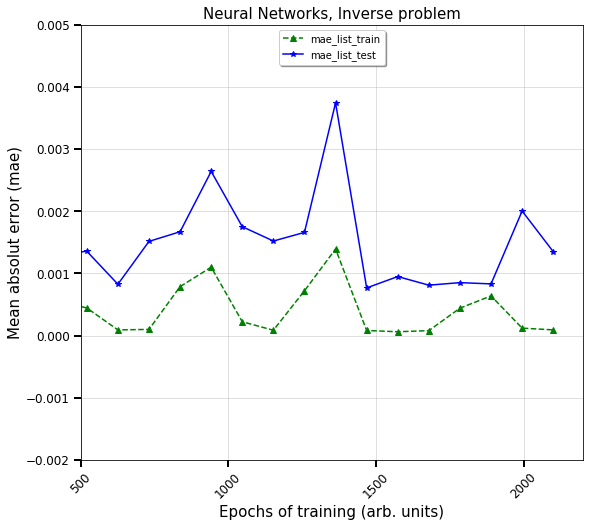

In [39]:

from pylab import figure, show, legend, ylabel
import matplotlib.ticker as ticker
# create the general figure
fig1 = figure(figsize=(9,8))
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
#line1 = ax1.errorbar(df_for1 ['Train_size'],df_for1 ['mean_Final_RMSE'], yerr=df_for1 ['std_final_rmse'],ecolor='black',fmt='--o',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='green')
#ax1.legend(['mean_RMSE_percentage'],loc=2)
#line1 = ax1.errorbar(df_for1 ['Train_size'],df_for1 ['training_rmse'], yerr=df_for1 ['std_final_rmse'],ecolor='black',fmt='--o',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='black')
plt.plot(np.linspace(100, 2100, num=20), mae_list_train_set, '--g^')
plt.plot(np.linspace(100, 2100, num=20), mae_list_test_set, '-b*')
#plt.plot(np.linspace(100, 2100, num=20), mae_list_val_set, '--r*')
plt.legend(('mae_list_train', 'mae_list_test', 'mae_list_val'),
           loc='upper center', shadow=True)
ylabel('Mean absolut error (mae)',fontsize=15)
plt.xlabel('Epochs of training (arb. units)',fontsize=15)
# now, the second axes that shares the x-axis with the ax1
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
#line2 = ax2.errorbar(df_new5 ['Train_size'],df_new5 ['mean_relative_absolute_error'], yerr=df_new5 ['std_mean_relative_absolute_error'],ecolor='black',fmt='xr-',capthick=2)
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.legend(["mean_rel_absolute_error"],loc=1)
#ylabel('mean_rel_absolute_error')
plt.title('Neural Networks, Inverse problem',fontsize=15)
plt.xticks(rotation = 45)

tick_spacing =500
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(direction='out', length=7, width=2,
                grid_alpha=0.5,labelsize=12)

#legend = ax1.legend(loc='down center', shadow=True, fontsize='x-large')
plt.xlim([500, 2200])
plt.ylim([-0.002,  0.005])
#ax1.set_yscale("log", nonposy='clip')
plt.grid(True)

show()

In [ ]:
#subplot different features errors

In [398]:
X_train

,Reflectance
93,"[0.0110753718997202, 0.0133324068909724, 0.014..."
16,"[0.0151877988882627, 0.0173596654497896, 0.018..."
73,"[0.0124214473106007, 0.0142867077334515, 0.014..."
54,"[0.0146143345988744, 0.015810803946462, 0.0158..."
95,"[0.0203499709151945, 0.0255063036653046, 0.028..."
...,...
96,"[0.0158880769961786, 0.0184102397047299, 0.020..."
67,"[0.0170166076114712, 0.019641518455933, 0.0199..."
64,"[0.0106301553707209, 0.0125945396402629, 0.012..."
47,"[0.0135969430382338, 0.0161451794148266, 0.016..."


#### For different train sizes

In [414]:
#Checking overfit for different epochs of training 
mean_mae_list_train_set = []
mean_mae_list_test_set = []
std_mae_list_train_set = []
std_mae_list_test_set = []
for test_size_value in [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]:
    mean_mae_train = []
    mean_mae_test = []
    print(test_size_value)
    for i in range(1,20,1):
        X_train, X_test, y_train, y_test = train_test_split(
        grouped_df.drop(['Simulation index', 'h','top','base'], axis=1), # predictive variables
        grouped_df[['h','top','base']], # target
        test_size = test_size_value, # portion of dataset to allocate to test set
        random_state=0, # we are setting the seed here
        )
        
        #transform onecolumn dataframe to num of values in least sized dataframe
        X_train = pd.DataFrame(X_train["Reflectance"].to_list())
        X_test = pd.DataFrame(X_test["Reflectance"].to_list())

        n_inputs, n_outputs = X_train.shape[1],3
        model = get_model(n_inputs, n_outputs)
        
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs = 2000)
        
        mean_mae_train.append( model.evaluate(X_train, y_train, verbose=0))
        mean_mae_test.append( model.evaluate(X_test, y_test, verbose=0) )
        

    # evaluate model on test set
    mean_mae_list_train_set.append(np.mean(mean_mae_train))
    mean_mae_list_test_set.append(np.mean(mean_mae_test))
    
    std_mae_list_train_set.append(np.std(mean_mae_train))
    std_mae_list_test_set.append(np.std(mean_mae_test))
    #for the subplot error
    
    df_pred = pd.DataFrame(data=pred, columns=['h','top','base'])
    
    
    del model
    #pred_2 = model.predict(df5[['h','top',	'base',	'wavelength']],df5['Reflectance'])
    #mae_list_val_set.append(model.evaluate(df5[['h','top',	'base',	'wavelength']], df5['Reflectance'], verbose=0))


0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5


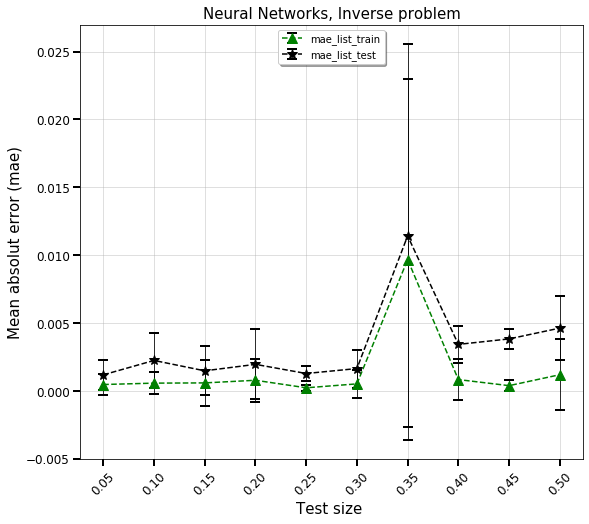

In [415]:
from pylab import figure, show, legend, ylabel
import matplotlib.ticker as ticker
# create the general figure
fig1 = figure(figsize=(9,8))
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
x_space = [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
line1 = ax1.errorbar(x_space,mean_mae_list_train_set, yerr=std_mae_list_train_set,ecolor='black',fmt='--^',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='green')
ax1.legend(['mean_RMSE_percentage'],loc=2)
line1 = ax1.errorbar(x_space,mean_mae_list_test_set, yerr=std_mae_list_test_set,ecolor='black',fmt='--*',capthick=2,capsize=5,elinewidth=0.8, markersize=10,color='black')

#plt.plot(x_space, mean_mae_list_train_set, '--g^')
#plt.plot(x_space, mean_mae_list_test_set, '-b*')
#plt.plot(np.linspace(100, 2100, num=20), mae_list_val_set, '--r*')
plt.legend(('mae_list_train', 'mae_list_test'),
           loc='upper center', shadow=True)
ylabel('Mean absolut error (mae)',fontsize=15)
plt.xlabel('Test size ',fontsize=15)
# now, the second axes that shares the x-axis with the ax1
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
#line2 = ax2.errorbar(df_new5 ['Train_size'],df_new5 ['mean_relative_absolute_error'], yerr=df_new5 ['std_mean_relative_absolute_error'],ecolor='black',fmt='xr-',capthick=2)
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.legend(["mean_rel_absolute_error"],loc=1)
#ylabel('mean_rel_absolute_error')
plt.title('Neural Networks, Inverse problem',fontsize=15)
plt.xticks(rotation = 45)

tick_spacing =0.05
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(direction='out', length=7, width=2,
                grid_alpha=0.5,labelsize=12)

#legend = ax1.legend(loc='down center', shadow=True, fontsize='x-large')

#ax1.set_yscale("log", nonposy='clip')
plt.grid(True)

show()

In [ ]:
#subplot different features errors


### Action points

**Forward problem**
* Max error
* Error for other spectra
* Error vs training size
* -> look up table


**Inverse problem**
* Overfiting search
*
*

-> spectrum -> (fowrad)-> Features ->(Inverse) -> Spectrum

In [448]:
df3.head()

,Simulation index,h,top,base,wavelength,Reflectance
0,1,0.0,0.0,0.0,0.000000,0.044171
1,1,0.0,0.0,0.0,0.010101,0.045151
2,1,0.0,0.0,0.0,0.020202,0.046044
3,1,0.0,0.0,0.0,0.030303,0.046886
4,1,0.0,0.0,0.0,0.040404,0.047678


In [449]:
grouped_df.head()

,Simulation index,h,top,base,Reflectance
0,1,0.0,0.0,0.000000,"[0.0441705845518706, 0.0451512878134928, 0.046..."
1,2,0.0,0.0,0.138889,"[0.0396313691881517, 0.040764051987158, 0.0417..."
2,3,0.0,0.0,0.277778,"[0.0345976283250554, 0.035954689964802, 0.0369..."
3,4,0.0,0.0,0.416667,"[0.0294282118029957, 0.0310594583102924, 0.032..."
4,5,0.0,0.0,0.555556,"[0.0244563302543115, 0.0263763566979613, 0.027..."


In [271]:

#inverse model:
model
#forward model:
model_fowward

NameError: name 'model_fowward' is not defined

In [272]:
#choose a spectrum
Simulation_ind = 40
grouped_df[grouped_df['Simulation index'] == Simulation_ind]

,Simulation index,h,top,base,Reflectance
39,40,0.333333,0.5,0.777778,"[0.0136327992003718, 0.0159041458823391, 0.016..."


In [273]:
h,top,base = model.predict(pd.DataFrame(grouped_df[grouped_df['Simulation index'] == Simulation_ind]["Reflectance"].to_list()))[0]

In [274]:
h,top,base

(0.32884833, 0.52384555, 0.746165)

In [275]:
df_helout = df3[df3['Simulation index'] == Simulation_ind]

In [276]:
df_helout['h'] = h
df_helout['top'] = top
df_helout['base'] = base

<ipython-input-276-fbf38d84c6e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_helout['h'] = h
<ipython-input-276-fbf38d84c6e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_helout['top'] = top
<ipython-input-276-fbf38d84c6e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [277]:
df_helout.head()

,Simulation index,h,top,base,wavelength,Reflectance
3900,40,0.328848,0.523846,0.746165,0.000000,0.013633
3901,40,0.328848,0.523846,0.746165,0.010101,0.015904
3902,40,0.328848,0.523846,0.746165,0.020202,0.016310
3903,40,0.328848,0.523846,0.746165,0.030303,0.016411
3904,40,0.328848,0.523846,0.746165,0.040404,0.016381


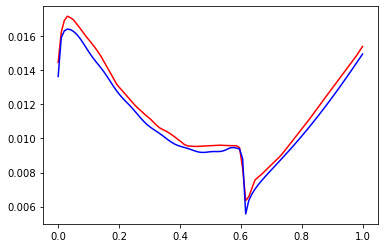

In [278]:
#39

pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

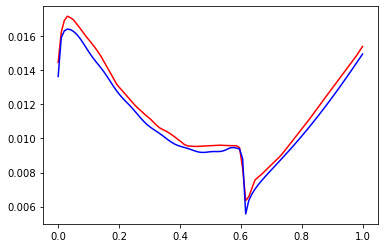

In [279]:
#40

pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()


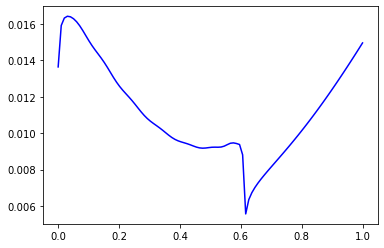

In [280]:
#40

pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

#plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

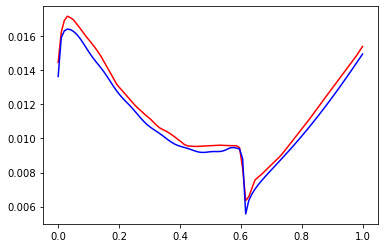

In [300]:
#41

pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()

### Testing model with data from additional runs (out of the feature gradings) 

In [166]:
#read the data with pandas and convert to a dataframe
df_test_out = pd.read_csv("data/Test model data/extra_11.txt", sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])

In [167]:
df_test_out

,h,top,base,wavelength,Reflectance
0,1.200000e-07,3.000000e-08,8.000000e-08,0.400000,0.005033
1,1.200000e-07,3.000000e-08,8.000000e-08,0.403030,0.007019
2,1.200000e-07,3.000000e-08,8.000000e-08,0.406061,0.007660
3,1.200000e-07,3.000000e-08,8.000000e-08,0.409091,0.008050
4,1.200000e-07,3.000000e-08,8.000000e-08,0.412121,0.008322
...,...,...,...,...,...
95,1.200000e-07,3.000000e-08,8.000000e-08,0.687879,0.009123
96,1.200000e-07,3.000000e-08,8.000000e-08,0.690909,0.009343
97,1.200000e-07,3.000000e-08,8.000000e-08,0.693939,0.009568
98,1.200000e-07,3.000000e-08,8.000000e-08,0.696970,0.009796


In [168]:
#convert to nanometers:
df_test_out['h'] = df_test_out['h']* 10**9
df_test_out['top'] = df_test_out['top']* 10**9
df_test_out['base'] = df_test_out['base']* 10**9
df_test_out['wavelength'] = df_test_out['wavelength']* 10**3

In [169]:
df_test_out

,h,top,base,wavelength,Reflectance
0,120.0,30.0,80.0,400.000000,0.005033
1,120.0,30.0,80.0,403.030303,0.007019
2,120.0,30.0,80.0,406.060606,0.007660
3,120.0,30.0,80.0,409.090909,0.008050
4,120.0,30.0,80.0,412.121212,0.008322
...,...,...,...,...,...
95,120.0,30.0,80.0,687.878788,0.009123
96,120.0,30.0,80.0,690.909091,0.009343
97,120.0,30.0,80.0,693.939394,0.009568
98,120.0,30.0,80.0,696.969697,0.009796


In [170]:
# Forward predict test

In [171]:
df_test_out[['h','top','base','wavelength']] = scaler_1.transform(df_test_out[['h','top','base','wavelength']])

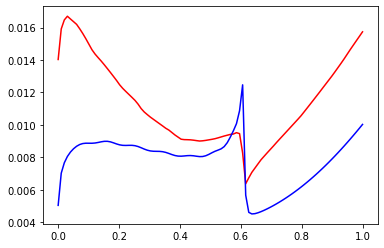

In [172]:
pre_heldout= model_forward.predict(df_test_out.drop(['Reflectance'], axis=1))

plt.plot(df_test_out['wavelength'], pre_heldout,'r') 
plt.plot(df_test_out['wavelength'], df_test_out['Reflectance'], 'b')
plt.show()

In [138]:
df_test_out

,h,top,base,wavelength,Reflectance
0,1.083333,0.75,0.444444,0.000000,0.008067
1,1.083333,0.75,0.444444,0.010101,0.009360
2,1.083333,0.75,0.444444,0.020202,0.010453
3,1.083333,0.75,0.444444,0.030303,0.011518
4,1.083333,0.75,0.444444,0.040404,0.012568
...,...,...,...,...,...
95,1.083333,0.75,0.444444,0.959596,0.017599
96,1.083333,0.75,0.444444,0.969697,0.017449
97,1.083333,0.75,0.444444,0.979798,0.017304
98,1.083333,0.75,0.444444,0.989899,0.017161


In [121]:
# Inverse test

In [122]:
pd.DataFrame(df_test_out["Reflectance"].to_list())

,0
0,0.030004
1,0.030986
2,0.031464
3,0.031883
4,0.032273
...,...
95,0.041637
96,0.041639
97,0.041641
98,0.041643


In [284]:
h,top,base = model.predict(pd.DataFrame(df_test_out["Reflectance"].to_list()))[0]

ValueError: in user code:

    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\AX-St\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_19 is incompatible with the layer: expected axis -1 of input shape to have value 100 but received input with shape [None, 1]


In [292]:
model.predict(pd.DataFrame(df_test_out["Reflectance"].to_list()).T)

InvalidArgumentError:  Matrix size-incompatible: In[0]: [1,200], In[1]: [100,100]
	 [[node sequential_19/dense_95/BiasAdd (defined at <ipython-input-290-ec1dee14000e>:1) ]] [Op:__inference_predict_function_559323]

Function call stack:
predict_function


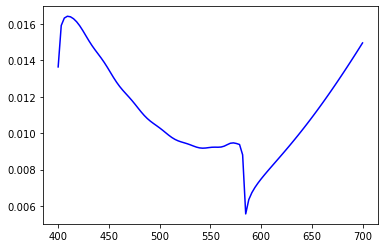

In [71]:

df_helout = df3[df3['Simulation index'] == 40]
#pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

#plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately 
plt.show()


In [72]:
df_helout

,Simulation index,h,top,base,wavelength,Reflectance
3900,40,120,30,80.0,400.000000,0.013633
3901,40,120,30,80.0,403.030303,0.015904
3902,40,120,30,80.0,406.060606,0.016310
3903,40,120,30,80.0,409.090909,0.016411
3904,40,120,30,80.0,412.121212,0.016381
...,...,...,...,...,...,...
3995,40,120,30,80.0,687.878788,0.013889
3996,40,120,30,80.0,690.909091,0.014151
3997,40,120,30,80.0,693.939394,0.014414
3998,40,120,30,80.0,696.969697,0.014680


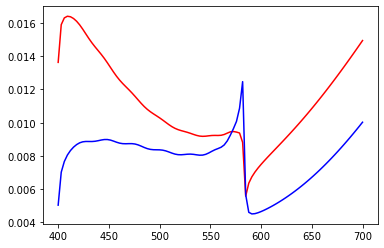

In [79]:
#pre_heldout= model_forward.predict(df_test_out.drop(['Reflectance'], axis=1))

plt.plot(df_helout['wavelength'], df_helout['Reflectance'],'r') 
plt.plot(df_test_out['wavelength'], df_test_out['Reflectance'], 'b')
plt.show()